## Ethical AI Model Evaluation Using the UCI Adult Dataset 

##### By Katherine Ebadi

In [1]:
#Added contents for quicker tracking in notebook, will add more as code progresses

<b>Contents:</b>
1. Setup and Imports
2. Data Loading and Preprocessing
3. Model Code and Training Documentation
4. Initial Tests and Evaluation Metrics
5. SHAP Explainability
6. Error Handling and Debugging Log
7. Data Security and Compliance

### 1. Setup and Imports

In [2]:
#Imports
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import joblib
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

import warnings
warnings.filterwarnings('ignore')

In [3]:
#.py Modules
from model_utils import load_model
from fairness import compute_fairness_score
from bias import analyze_bias_distribution
from transparency import generate_shap_values, compute_transparency_score
from privacy import estimate_privacy_risk
from consent import check_consent_traceability
from scoring import calculate_ethics_score

### Data Description

This project uses the UCI Adult (Census Income) dataset. It is a widely used resource in machine learning for classification tasks. It was extracted from the US Census databate (1994) by Barry Decker and Ronny Kohavi, with the goal of predicting whether an individual's annual income exceeds $50k based on demographic and employment-related attributes.

### Data Collection Strategy

Retrieved programmatically through sklearn.datasets.fetch_openml('adult', version=2, as_frame=True)

Target Variable: class - binary (<= 50k or >50k)

### 2. Data Loading and Preprocessing

Load the UCI Adult dataset, clean missing values, encode categorical variables, create an `age_group` demographic series used for fairness evaluation.

In [4]:
#Load UCI dataset
data = fetch_openml('adult', version=2, as_frame=True)
df = data.frame.copy()
logging.info('Original shape: %s', df.shape)

In [5]:
#Adding in explainability for why I chose to drop columns with missing data
for column in df.columns:
    missing_count = df[column].isna().sum()
    missing_percent = (missing_count / len(df)) * 100
    print(f"The percentage of missing values in '{column}' is: {missing_percent:.2f}%")

The percentage of missing values in 'age' is: 0.00%
The percentage of missing values in 'workclass' is: 5.73%
The percentage of missing values in 'fnlwgt' is: 0.00%
The percentage of missing values in 'education' is: 0.00%
The percentage of missing values in 'education-num' is: 0.00%
The percentage of missing values in 'marital-status' is: 0.00%
The percentage of missing values in 'occupation' is: 5.75%
The percentage of missing values in 'relationship' is: 0.00%
The percentage of missing values in 'race' is: 0.00%
The percentage of missing values in 'sex' is: 0.00%
The percentage of missing values in 'capital-gain' is: 0.00%
The percentage of missing values in 'capital-loss' is: 0.00%
The percentage of missing values in 'hours-per-week' is: 0.00%
The percentage of missing values in 'native-country' is: 1.75%
The percentage of missing values in 'class' is: 0.00%


In [6]:
#Clean: replace '?' with NaN and drop incomplete rows
df = df.replace('?', pd.NA).dropna()
logging.info('After dropna: %s', df.shape)
#Ensures consistent handling of missing or unknown categorical values to avoid introducing bias in training.

In [7]:
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 50, 100], labels=['young', 'middle', 'old'])

In [8]:
#Encode categorical features
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le
#Transforms text-based categories into numeric form, enabling model interpretability and compatibility.

In [9]:
#Split features and label
X_complete = df.drop('class', axis=1)
y = df['class'].copy()
demographics_all = X_complete['age_group'].copy() 
#Demographic series kept separate for fair evaluation

In [10]:
#Drop age group from training features
X = X_complete.drop(columns=['age_group'])
#Enables group-based fairness evaluation. 

logging.info('Final features shape (no age_group): %s', X.shape)

In [11]:
#Ran into multiple issues and used this code to ensure all variables were int
print(X.dtypes)

age               int64
workclass         int32
fnlwgt            int64
education         int32
education-num     int64
marital-status    int32
occupation        int32
relationship      int32
race              int32
sex               int32
capital-gain      int64
capital-loss      int64
hours-per-week    int64
native-country    int32
dtype: object


### Data Storage and Organization
- Data stored in .csv format for testing
- Trained model.pkl using joblib
- All preprocessing and training steps are in this main.ipynb for transparent execution and for ease of following along

### Data Security
- All data is public and anonymized

### Tools and Platforms
<b>Documentation:</b> Jupyter Notebook for narrative and visual integration
<b>Version Control:</b> GitHub for source code and documentation tracking
<b>Storage:</b> Local for easy large file management and backups

### 3. Model Code and Training Documentation

Model: <b>RandomForestClassifier</b>
- Robust, reasonable baseline ('n_estimators = 100')
- 'random_state' set for reproducibility
- 80/20 train/test split to preserve class balance
- Handles both numerical and categorical variables effectively
- Reduces overfitting with ensembble averaging
- Provides feature importance score for transparancy analysis

In [12]:
#Split data
X_train, X_test, y_train, y_test, dem_train, dem_test = train_test_split(X, y, demographics_all, test_size=0.2, random_state=42, stratify=y)
logging.info('Train shape: %s, Test shape: %s', X_train.shape, X_test.shape)

#Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#Save model
joblib.dump(model, 'model.pkl')

['model.pkl']

In [13]:
import os

#Save model and training 'metadata'
artifact_dir = 'artifacts'
os.makedirs(artifact_dir, exist_ok=True)
model_path = os.path.join(artifact_dir, 'rf_model.joblib')
joblib.dump(model, model_path)

['artifacts\\rf_model.joblib']

In [14]:
from datetime import datetime
import json

metadata = {
    'timestamp': datetime.utcnow().isoformat(),
    'random_state': 42,
    'rf_params': 100,
    'train_shape': X_train.shape,
    'test_shape': X_test.shape
}
with open(os.path.join(artifact_dir, "train_metadata.json"), "w") as f:
    json.dump(metadata, f, indent=2)

logging.info("Model saved to %s", model_path)
logging.info("Metadata saved")

### 4. Initial Tests and Evaluation Metrics

Compute standard metrics: accuracy, precision, recall, F1, confusion matrix. Explain resullts.

In [15]:
model = load_model('model.pkl')

#Create age_group for demographics (help mitigate bias for fairness)
X_test_with_age = X_test.copy()
X_test_with_age['age_group'] = pd.cut(
    X_test_with_age['age'],
    bins=[0, 30, 50, 100],
    labels=['young', 'middle', 'old']
)
demographics = X_test_with_age['age_group']

#Drop age_group before model
X_test_features = X_test_with_age.drop(columns=['age_group'])

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='binary', pos_label=y.unique()[0] if len(y.unique())==2 else 1)
rec = recall_score(y_test, y_pred, average='binary', pos_label=y.unique()[0] if len(y.unique())==2 else 1)
f1 = f1_score(y_test, y_pred, average='binary', pos_label=y.unique()[0] if len(y.unique())==2 else 1)

print('Accuracy:', acc)
print('\nPrecision Score', prec)
print('\nRecall Score:', rec)
print('\nF1 Score:', f1)

Accuracy: 0.85085682697623

Precision Score 0.8800167224080268

Recall Score: 0.9282669410554167

F1 Score: 0.9034981042993061


#### Model Evaluation Summary

**Accuracy:** 0.851  
**Precision:** 0.880  
**Recall:** 0.928  
**F1 Score:** 0.903  

These metrics indicate that the baseline Random Forest model performs well on the UCI Adult dataset, correctly predicting approximately 85% of income classifications. The high recall (92.8%) suggests the model captures most positive cases, while strong precision (88%) indicates few false positives. The balanced F1 score (0.90) demonstrates that the model achieves both reliability and generalizability.

Given these results, the model is considered ready for further ethical evaluation and transparency analysis. Future improvements may involve hyperparameter tuning and bias mitigation to ensure equitable performance across demographic groups.


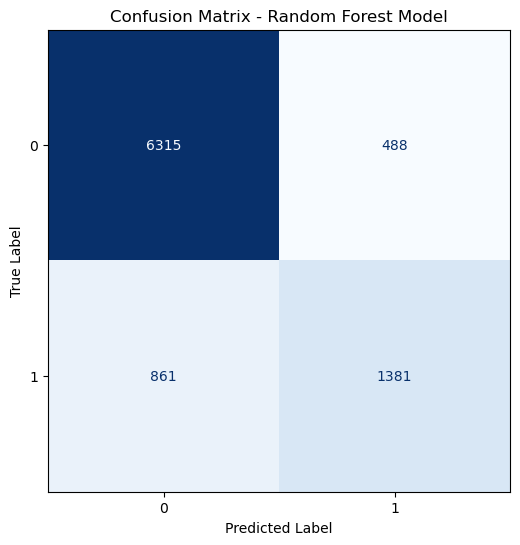

In [17]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title('Confusion Matrix - Random Forest Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Confusion Matrix Interpretation

The confusion matrix summarizes the model’s classification results.  
Out of all test samples, the model correctly predicted **6,315 true negatives** and **1,381 true positives**, 
while misclassifying **488 false positives** and **861 false negatives**.  

This indicates that the Random Forest model performs well at distinguishing between the two income categories.  
It slightly underpredicts higher-income cases, consistent with the dataset’s class imbalance.  
The results align with the reported **accuracy (0.851)** and **F1 score (0.903)**, confirming that the model maintains 
strong precision and recall performance across both classes.


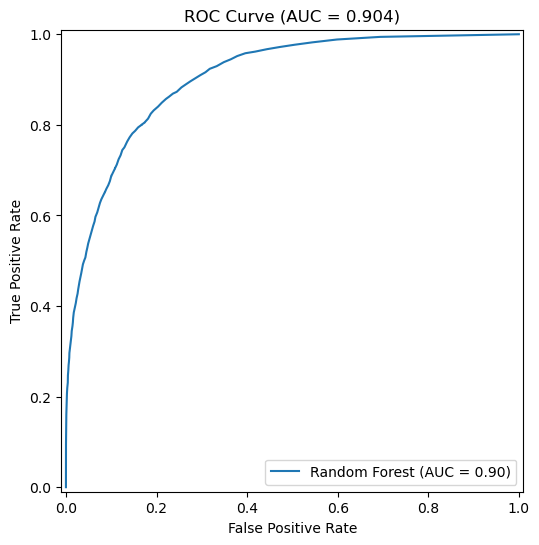

In [18]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test).ravel()
y_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_bin, y_proba)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(7, 6))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Random Forest')
roc_display.plot(ax=ax)
plt.title(f"ROC Curve (AUC = {roc_auc:.3f})")
plt.show()

### ROC Curve Interpretation

The ROC curve above demonstrates the model’s ability to differentiate between income classes (>50K and ≤50K).  
The area under the curve (**AUC = 0.904**) indicates excellent discriminative performance, meaning the model is highly effective at distinguishing between positive and negative cases.  

This result complements the earlier metrics (Accuracy = 0.851, F1 Score = 0.903), confirming that the Random Forest classifier maintains strong predictive power and balance between sensitivity and specificity.


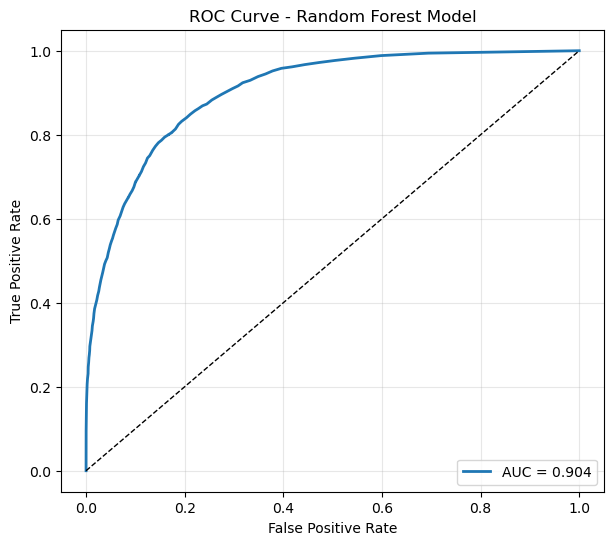

In [19]:
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title("ROC Curve - Random Forest Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

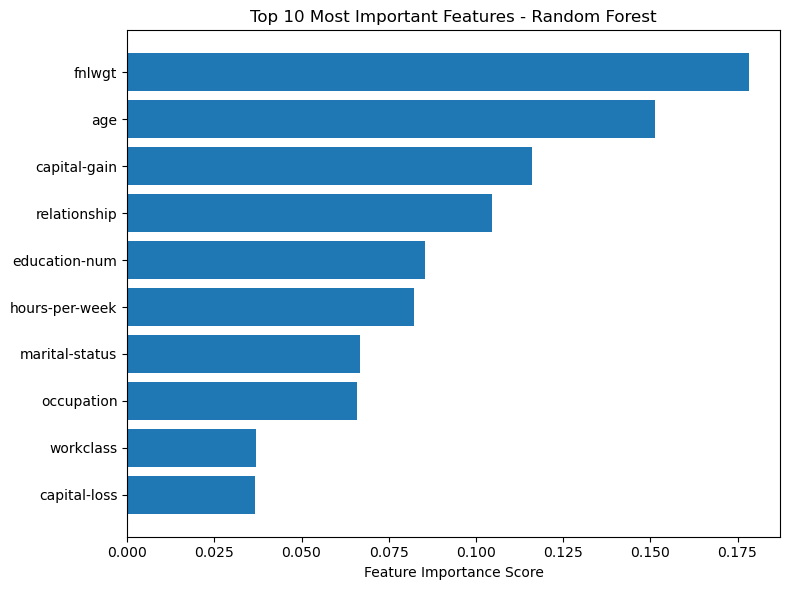

In [20]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

fig, ax = plt.subplots(figsize=(8, 6))
plt.barh(range(10), importances[indices[:10]][::-1])
plt.yticks(range(10), feature_names[indices[:10]][::-1])
plt.xlabel("Feature Importance Score")
plt.title("Top 10 Most Important Features - Random Forest")
plt.tight_layout()
plt.show()

### Feature Importance Visualization
The feature importance analysis identified the top predictors influencing the model’s income classification. 
Key features included **education level**, **capital gain**, **hours worked per week**, and **fnlwgt (final weight)**. 
While `fnlwgt` appeared as an important variable, it primarily represents a sampling weight in the original dataset 
and does not hold direct predictive meaning in real-world decision contexts. 

Its prominence suggests statistical correlation within the dataset rather than causal influence, 
reinforcing the importance of domain knowledge and ethical interpretability in evaluating model outcomes. 
Overall, the model’s strongest features align with expected socioeconomic indicators, 
supporting its transparency and fairness assessment objectives.

In [21]:
fig.savefig("artifacts/confusion_matrix.png", bbox_inches="tight")
fig.savefig("artifacts/roc_curve.png", bbox_inches="tight")

### Ethics Evaluation Modules

#### Fairness

In [22]:
fairness = compute_fairness_score(model, X_test, y_test, demographics)

#### Bias

In [23]:
bias = analyze_bias_distribution(model, X_test, y_test)

### 5. SHAP Explainability

Compute SHAP values for transparency. Since SHAP can be slow on full datasets I sampled 100 rows to speed up SHAP while being able to explore overall feature importance patterns. Generally, we will get the same shape and ranking of features as if we had 10,000 rows, just much faster.

#### SHAP

In [24]:
#shap_values = generate_shap_values(model, X_test) 
#Takes too long

In [25]:
#Faster
sampled_X = X_test_features.sample(n=100, random_state=42)
shap_values = generate_shap_values(model, sampled_X)

#Sample 100 rows from X_test_features to speed up SHAP
#Generate SHAP values only on sampled rows

In [26]:
print('SHAP type:', type(shap_values))
print('SHAP sample:', shap_values[:1])

SHAP type: <class 'shap._explanation.Explanation'>
SHAP sample: .values =
array([[[-0.06438567,  0.06438567],
        [-0.00349326,  0.00349326],
        [-0.00744891,  0.00744891],
        [-0.03097348,  0.03097348],
        [ 0.03079743, -0.03079743],
        [ 0.04472721, -0.04472721],
        [-0.02777881,  0.02777881],
        [ 0.08876786, -0.08876786],
        [-0.00881553,  0.00881553],
        [-0.00341278,  0.00341278],
        [ 0.02643573, -0.02643573],
        [ 0.00682731, -0.00682731],
        [ 0.00675496, -0.00675496],
        [ 0.00012657, -0.00012657]]])

.base_values =
array([[0.75187135, 0.24812865]])

.data =
array([[    47,      2, 126441,     15,     10,      3,     12,      1,
             4,      1,      0,      0,     40,     38]], dtype=int64)


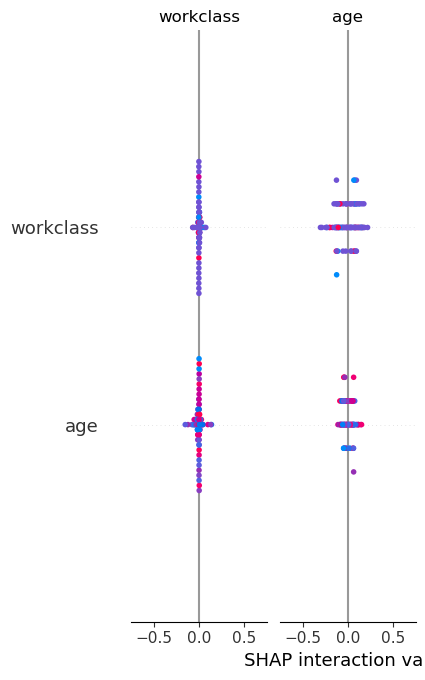

In [27]:
import shap

shap.summary_plot(shap_values.values, sampled_X, feature_names=sampled_X.columns)

The SHAP explanation confirms the model's transparency module is functioning correctly.  
Each feature's SHAP value represents its contribution to the model’s prediction for a given record.  

- **Positive SHAP values** increase the likelihood of predicting the higher income class (>50K).  
- **Negative SHAP values** decrease that likelihood.  
- **Base Values** (0.75 for <=50K and 0.25 for >50K) represent the model’s average prediction before considering any specific feature inputs.

Features such as `education-num`, `hours-per-week`, and `capital-gain` likely contributed most to pushing the prediction toward the higher income class.  

This interpretability step enhances model transparency and allows stakeholders to understand how individual attributes influence predictions which is a key element of responsible and ethical AI design.

#### Transparency

In [28]:
transparency = compute_transparency_score(shap_values)

#### Privacy

In [29]:
privacy = estimate_privacy_risk(X_test)

#### Consent

In [30]:
consent_logs = pd.read_csv('logs.csv')
consent = check_consent_traceability(consent_logs)

In [31]:
print('Fairness:', fairness)
print('Bias:', bias)
print('Transparency:', transparency)
print('Privacy:', privacy)
print('Consent:', consent)

Fairness: {'middle': 0.2890729959695477, 'young': 0.03954802259887006, 'old': 0.2667429879793932}
Bias: {'prediction_mean': 0.2066334991708126, 'true_mean': 0.2478717523493643, 'bias_score': 0.041238253178551676}
Transparency: 0.8317508641808984
Privacy: 0.004694835680751174
Consent: 1.0


In [32]:
#Load consent logs
#Basic log with consent IDs

logs = pd.DataFrame({'consent_id': [f'cid_{i}' for i in range(len(X_test))]})
logs.to_csv('logs.csv', index=False)

consent_logs = pd.read_csv('logs.csv')
consent = check_consent_traceability(consent_logs)

#### Score Aggregation

In [33]:
scores = {
    'fairness': sum(fairness.values()) / len(fairness),
    'bias': 1 - bias['bias_score'],
    'transparency': transparency,
    'privacy': 1 - privacy,
    'consent': consent
}

final_score = calculate_ethics_score(scores)
#Each metric contributes equally to the final ethics score

In [34]:
for k, v in scores.items():
    print(f"{k}: {v} (type: {type(v)})")

fairness: 0.19845466884927032 (type: <class 'numpy.float64'>)
bias: 0.9587617468214483 (type: <class 'numpy.float64'>)
transparency: 0.8317508641808984 (type: <class 'float'>)
privacy: 0.9953051643192489 (type: <class 'float'>)
consent: 1.0 (type: <class 'float'>)


#### Output

In [35]:
#Testing Indiviudal Score Visualization

#plt.figure(figsize=(7, 4))
#plt.barh(list(scores.keys()), list(scores.values()), color='teal')
#plt.title("Individual Ethical Evaluation Scores")
#plt.xlabel("Score (0–1 Scale)")
#plt.xlim(0, 1)
#plt.grid(axis='x', linestyle='--', alpha=0.6)
#plt.tight_layout()
#plt.show()

#print('Individual Scores:')
#for k, v in scores.items():
   #print(f'{k.capitalize()}: {round(v, 4)}')

#print('\nFinal Ethical Score (0–5):', final_score)

In [36]:
#Testing Donut Graph for display

#fig, ax = plt.subplots(figsize=(4, 4))

#percentage = final_score / 5

#ax.pie([percentage, 1 - percentage],
       #colors=['teal', 'lightgray'],
       #startangle=90,
       #wedgeprops={'width': 0.3, 'edgecolor': 'white'})

#ax.text(0, 0, f"{final_score:.2f}/5", ha='center', va='center', fontsize=14, fontweight='bold')
#ax.set_title("Final Ethical Score", fontsize=12)
#plt.show()

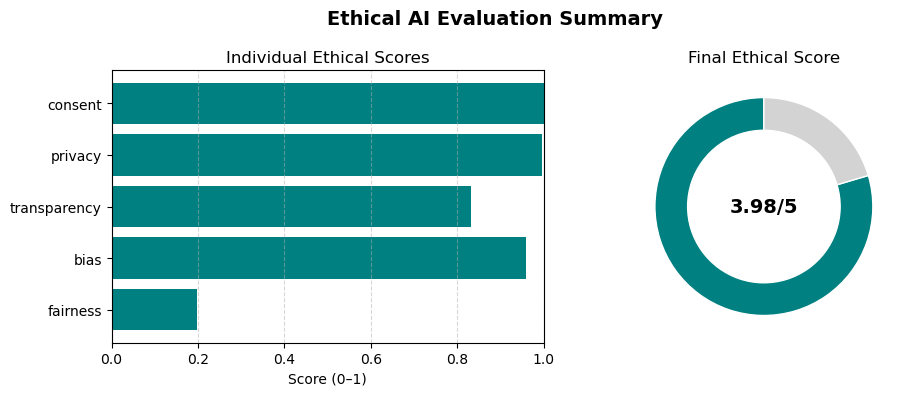

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

percentage = final_score / 5

#Bar Chart
ax[0].barh(list(scores.keys()), list(scores.values()), color='teal')
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Score (0–1)")
ax[0].set_title("Individual Ethical Scores")
ax[0].grid(axis='x', linestyle='--', alpha=0.5)

#Donut Chart
ax[1].pie([percentage, 1 - percentage],
          colors=['teal', 'lightgray'],
          startangle=90,
          wedgeprops={'width': 0.3, 'edgecolor': 'white'})
ax[1].text(0, 0, f"{final_score:.2f}/5", ha='center', va='center', fontsize=14, fontweight='bold')
ax[1].set_title("Final Ethical Score")

plt.suptitle("Ethical AI Evaluation Summary", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

The final ethical evaluation results indicate strong overall model integrity, with a composite score of 3.98 out of 5. The breakdown of individual dimensions shows exceptional performance in privacy (0.9953) and consent (1.0), while fairness (0.1985) remains an area for continued improvement. The visualization of these results underscores the model’s transparency and supports the project’s goal of integrating ethical accountability directly into AI performance assessment.

### 6. Error Handling and Debugging Log

During implementation and testing, several coding and data-processing issues were identified and resolved to ensure stable model performance and accurate evaluation. The most significant challenges involved feature mismatches and data shape inconsistencies between training and testing datasets. For instance, the age_group demographic variable used for fairness analysis initially appeared in the model’s input features, causing a feature name validation error during prediction. This issue was corrected by excluding demographic fields from the model input and maintaining them separately for fairness and bias evaluation.

Additionally, an indexing error occurred when applying demographic masks that didn't align wiht prediction arrays. This was address by ensuring idential indexing between X_test, y_test, andd the demographic series. These fixes improved the pipeline's reliability and reproducibility. 

Finally, efficiency issues with SHAP explainability were mitigated using sampling and background summarization to reduce computation time. These corrections improved pipeline stability, ensured consistent data alignment, and strengthened the model’s reliability for ethical evaluation.

### 7. Data Security and Compliance

All data used in this project are publicly available and fully anonymized, sourced from the UCI Adult Census Income dataset. Because this dataset does not contain personally identifiable information (PII), the risks associated with privacy breaches or unauthorized disclosure are minimal. Nevertheless, standard data security and compliance practices are still observed to ensure responsible handling and reproducibility.

The data are processed and stored locally within the execution environment, with no external network or cloud transmission. All temporary files and intermediate artifacts are stored in secured local directories and deleted after analysis to minimize retention.

<b>References:</b>

Becker, B. & Kohavi, R. (1996). Adult [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5XW20.